# FMLIKH Model: Startup Shear

## Protocol-Specific Context (Multi-Mode)

**FMLIKH startup shear** reveals **multi-timescale relaxation** combined with fractional memory:

1. **Multiple overshoot features**: Each mode $i$ contributes overshoot at different times $t_i \sim \tau_i$
2. **Distributed power-law decay**: Each $\lambda_i$ follows Mittag-Leffler decay with rate $\sim t^{-\alpha_i}$
3. **Composite stress response**: $\sigma(t) = \sum_i \sigma_i(t) + \eta_{\infty}\dot{\gamma}$

**Why this matters**: Single-mode FIKH produces one overshoot. FMLIKH with N=3 can show **early, intermediate, and late overshoots** corresponding to fast, medium, and slow structural modes breaking down at different rates. This captures complex experimental startup curves that single-mode models cannot fit.

> **Physical insight**: Fast modes ($\tau_1 \sim 1$ s) break early → sharp initial overshoot. Slow modes ($\tau_3 \sim 100$ s) break late → secondary hump or extended tail. Fractional kinetics broadens each feature.

> **Handbook:** See [FMLIKH Documentation](../../docs/source/models/fikh/fmlikh.rst) for multi-mode transient analysis.

## Learning Objectives

1. Simulate FMLIKH startup with N=3 modes
2. Observe multiple overshoot features from different timescales
3. Analyze mode-by-mode stress contributions
4. Compare FMLIKH vs single-mode FIKH startup
5. Understand how shared vs per-mode $\alpha$ affects overshoot shapes

## Prerequisites

- NB07: FMLIKH flow curve (parameter calibration)
- NB02: FIKH startup (single-mode baseline)

**Estimated Time:** 4-6 minutes (fast), 15-20 minutes (full)

## 1. Setup

In [1]:
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"

In [2]:
%matplotlib inline
import os
import sys
import time
import warnings

# Robust path resolution for execution from any directory
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fikh import FMLIKH

_nb_dir = Path(__file__).parent if "__file__" in dir() else Path.cwd()
_utils_candidates = [_nb_dir / ".." / "utils", Path("examples/utils"), _nb_dir.parent / "utils"]
for _p in _utils_candidates:
    if (_p / "fikh_tutorial_utils.py").exists():
        sys.path.insert(0, str(_p.resolve()))
        break
from fikh_tutorial_utils import (
    compute_fit_quality,
    get_fmlikh_param_names,
    load_pnas_startup,
    print_convergence_summary,
    save_fikh_results,
)

# Shared plotting utilities
sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

# FAST_MODE: controlled by environment variable
FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"

jax, jnp = safe_import_jax()
verify_float64()

print(f"FAST_MODE: {FAST_MODE}")

FAST_MODE: True


## 2. Load Data

In [3]:
GAMMA_DOT = 1.0
time_data, stress_data = load_pnas_startup(gamma_dot=GAMMA_DOT)
strain_data = GAMMA_DOT * time_data

print(f"Data points: {len(time_data)}")
print(f"Shear rate: {GAMMA_DOT} 1/s")

Data points: 500
Shear rate: 1.0 1/s


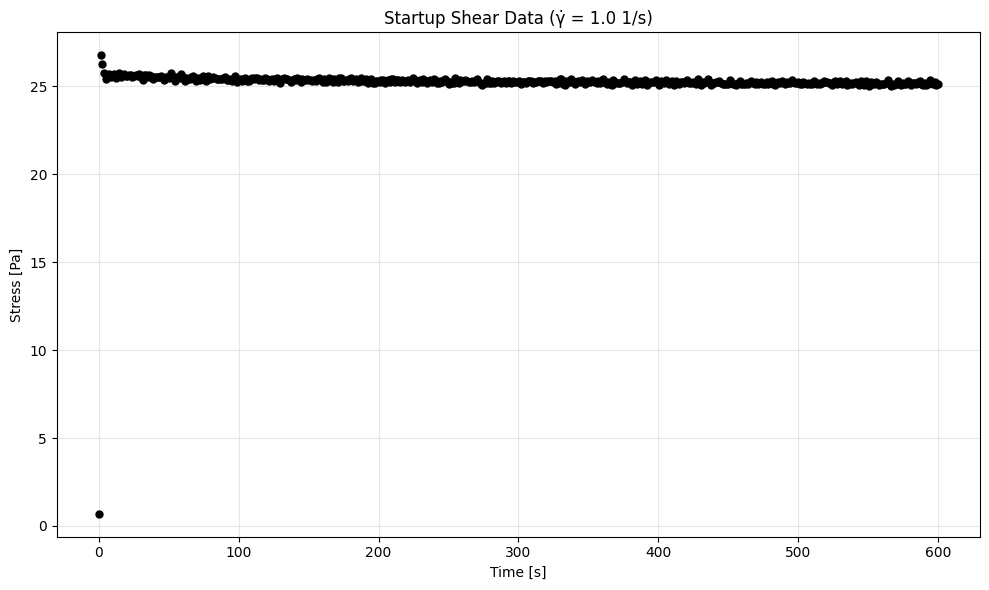

In [4]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(time_data, stress_data, "ko", markersize=5)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Stress [Pa]")
ax.set_title(f"Startup Shear Data (γ̇ = {GAMMA_DOT} 1/s)")
ax.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

## 3. NLSQ Fitting

In [5]:
N_MODES = 3
model = FMLIKH(n_modes=N_MODES, include_thermal=False, shared_alpha=True, alpha_structure=0.7)

t0 = time.time()
model.fit(time_data, stress_data, test_mode="startup", strain=strain_data, method='scipy')
t_nlsq = time.time() - t0

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"\nMode info:")
for m in model.get_mode_info()["modes"]:
    print(f"  Mode {m['mode']}: G={m['G']:.4g}, τ={m['tau']:.4g}")

ERROR:rheojax.core.base:Predict failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/base.py", line 713, in predict
    result = self._predict(X, **kwargs)
  File "/Users/b80985/Projects/rheojax/rheojax/models/fikh/fmlikh.py", line 561, in _predict
    times, strains = self._extract_time_strain(X, **kwargs)
                     ~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/rheojax/models/fikh/_base.py", line 335, in _extract_time_strain
    raise ValueError(
    ...<2 lines>...
    )
ValueError: FIKH models require both time and strain history. Pass RheoData, X of shape (2, N), or X=time with strain kwarg.


NLSQ fit time: 0.85 s

Mode info:
  Mode 0: G=1000, τ=1000
  Mode 1: G=157.5, τ=635
  Mode 2: G=20.35, τ=491.5


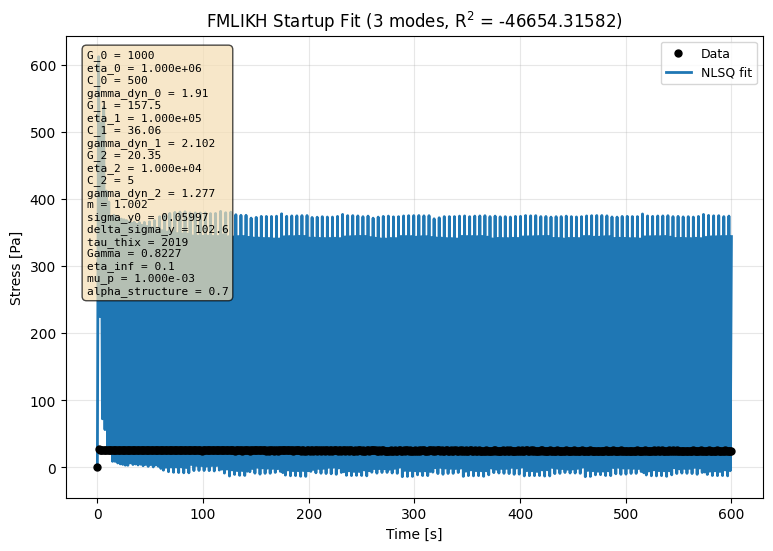

In [6]:
metrics = compute_fit_quality(stress_data, model.predict(time_data, test_mode="startup", strain=strain_data))

fig, ax = plot_nlsq_fit(
    time_data, stress_data, model, test_mode="startup",
    param_names=get_fmlikh_param_names(n_modes=N_MODES, shared_alpha=True),
    log_scale=False,
    xlabel="Time [s]", ylabel="Stress [Pa]",
    title=f"FMLIKH Startup Fit ({N_MODES} modes, R$^2$ = {metrics['R2']:.5f})",
    x_pred=time_data,
    strain=strain_data,
)
display(fig)
plt.close(fig)

## 4. Bayesian Inference

In [7]:
param_names = get_fmlikh_param_names(n_modes=N_MODES, shared_alpha=True)
initial_values = {n: model.parameters.get_value(n) for n in param_names if n in model.parameters}

NUM_WARMUP, NUM_SAMPLES, NUM_CHAINS = 200, 500, 1

t0 = time.time()
result = model.fit_bayesian(
    time_data, stress_data, test_mode="startup", strain=strain_data,
    num_warmup=NUM_WARMUP, num_samples=NUM_SAMPLES, num_chains=NUM_CHAINS,
    initial_values=initial_values, seed=42,
)
print(f"Bayesian time: {time.time() - t0:.1f} s")

  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:02<30:22,  2.61s/it, 1 steps of size 1.95e+00. acc. prob=0.00]

warmup:   1%|▏         | 10/700 [00:02<02:17,  5.01it/s, 3 steps of size 2.39e-09. acc. prob=0.20]

warmup:   2%|▏         | 15/700 [00:03<02:00,  5.70it/s, 7 steps of size 1.33e-09. acc. prob=0.41]

warmup:   3%|▎         | 18/700 [00:03<01:43,  6.58it/s, 3 steps of size 4.18e-09. acc. prob=0.50]

warmup:   3%|▎         | 21/700 [00:03<01:29,  7.60it/s, 31 steps of size 6.18e-10. acc. prob=0.52]

warmup:   3%|▎         | 23/700 [00:04<02:09,  5.23it/s, 127 steps of size 7.71e-10. acc. prob=0.55]

warmup:   4%|▎         | 25/700 [00:05<02:14,  5.03it/s, 63 steps of size 5.37e-10. acc. prob=0.57] 

warmup:   4%|▍         | 27/700 [00:05<01:52,  5.98it/s, 7 steps of size 1.40e-09. acc. prob=0.60] 

warmup:   4%|▍         | 30/700 [00:05<01:21,  8.18it/s, 3 steps of size 4.22e-09. acc. prob=0.64]

warmup:   5%|▍         | 33/700 [00:05<01:04, 10.34it/s, 15 steps of size 1.07e-09. acc. prob=0.64]

warmup:   5%|▌         | 36/700 [00:05<00:51, 12.92it/s, 7 steps of size 3.25e-09. acc. prob=0.67] 

warmup:   6%|▌         | 39/700 [00:05<00:48, 13.72it/s, 7 steps of size 2.43e-09. acc. prob=0.68]

warmup:   6%|▌         | 41/700 [00:06<00:46, 14.26it/s, 15 steps of size 1.41e-09. acc. prob=0.68]

warmup:   6%|▌         | 43/700 [00:06<00:44, 14.90it/s, 3 steps of size 2.93e-09. acc. prob=0.69] 

warmup:   7%|▋         | 47/700 [00:06<00:32, 19.97it/s, 3 steps of size 3.45e-09. acc. prob=0.71]

warmup:   7%|▋         | 51/700 [00:06<00:29, 21.82it/s, 15 steps of size 1.51e-09. acc. prob=0.71]

warmup:   8%|▊         | 54/700 [00:06<00:34, 18.96it/s, 15 steps of size 2.22e-09. acc. prob=0.72]

warmup:   8%|▊         | 58/700 [00:06<00:27, 22.99it/s, 3 steps of size 3.82e-09. acc. prob=0.73] 

warmup:   9%|▊         | 61/700 [00:06<00:35, 18.11it/s, 7 steps of size 1.29e-09. acc. prob=0.73]

warmup:   9%|▉         | 64/700 [00:07<00:31, 19.97it/s, 3 steps of size 3.05e-09. acc. prob=0.74]

warmup:  10%|▉         | 67/700 [00:07<00:38, 16.39it/s, 7 steps of size 9.84e-10. acc. prob=0.74]

warmup:  10%|█         | 71/700 [00:07<00:31, 20.16it/s, 3 steps of size 3.34e-09. acc. prob=0.75]

warmup:  11%|█         | 75/700 [00:07<00:28, 21.82it/s, 15 steps of size 1.41e-09. acc. prob=0.75]

warmup:  11%|█▏        | 79/700 [00:07<00:24, 25.29it/s, 3 steps of size 3.69e-09. acc. prob=0.76] 

warmup:  12%|█▏        | 84/700 [00:07<00:23, 25.72it/s, 15 steps of size 1.73e-09. acc. prob=0.76]

warmup:  12%|█▏        | 87/700 [00:08<00:23, 25.90it/s, 3 steps of size 3.29e-09. acc. prob=0.77] 

warmup:  13%|█▎        | 90/700 [00:08<00:24, 24.90it/s, 15 steps of size 1.45e-09. acc. prob=0.77]

warmup:  14%|█▎        | 95/700 [00:08<00:19, 30.66it/s, 3 steps of size 3.72e-09. acc. prob=0.78] 

warmup:  14%|█▍        | 99/700 [00:08<00:21, 28.40it/s, 7 steps of size 2.79e-09. acc. prob=0.78]

warmup:  15%|█▍        | 103/700 [00:10<01:28,  6.74it/s, 7 steps of size 4.47e-08. acc. prob=0.78]

warmup:  15%|█▌        | 106/700 [00:10<01:28,  6.68it/s, 63 steps of size 4.81e-08. acc. prob=0.79]

warmup:  16%|█▌        | 109/700 [00:10<01:11,  8.26it/s, 3 steps of size 1.22e-07. acc. prob=0.79] 

warmup:  16%|█▌        | 111/700 [00:10<01:13,  7.96it/s, 31 steps of size 6.16e-08. acc. prob=0.79]

warmup:  16%|█▌        | 113/700 [00:11<01:11,  8.24it/s, 3 steps of size 1.04e-07. acc. prob=0.80] 

warmup:  17%|█▋        | 117/700 [00:11<00:50, 11.48it/s, 7 steps of size 1.49e-07. acc. prob=0.80]

warmup:  17%|█▋        | 119/700 [00:11<00:54, 10.61it/s, 31 steps of size 3.58e-08. acc. prob=0.80]

warmup:  17%|█▋        | 121/700 [00:11<00:58,  9.96it/s, 31 steps of size 6.22e-08. acc. prob=0.80]

warmup:  18%|█▊        | 125/700 [00:11<00:44, 12.83it/s, 15 steps of size 1.08e-07. acc. prob=0.81]

warmup:  18%|█▊        | 127/700 [00:12<00:43, 13.06it/s, 7 steps of size 9.32e-08. acc. prob=0.81] 

warmup:  19%|█▊        | 131/700 [00:12<00:36, 15.51it/s, 15 steps of size 7.97e-08. acc. prob=0.81]

warmup:  19%|█▉        | 134/700 [00:12<00:38, 14.57it/s, 31 steps of size 5.29e-08. acc. prob=0.81]

warmup:  19%|█▉        | 136/700 [00:12<00:49, 11.28it/s, 31 steps of size 7.50e-08. acc. prob=0.81]

warmup:  20%|█▉        | 138/700 [00:13<00:57,  9.69it/s, 15 steps of size 5.99e-08. acc. prob=0.81]

warmup:  20%|██        | 140/700 [00:13<01:00,  9.32it/s, 31 steps of size 7.65e-08. acc. prob=0.82]

warmup:  20%|██        | 143/700 [00:13<01:08,  8.17it/s, 61 steps of size 1.88e-08. acc. prob=0.81]

warmup:  21%|██        | 145/700 [00:14<01:11,  7.79it/s, 31 steps of size 3.08e-08. acc. prob=0.82]

warmup:  21%|██        | 148/700 [00:14<01:04,  8.51it/s, 31 steps of size 6.00e-08. acc. prob=0.82]

warmup:  21%|██▏       | 150/700 [00:14<01:21,  6.71it/s, 63 steps of size 4.59e-08. acc. prob=0.82]

warmup:  22%|██▏       | 153/700 [00:15<01:01,  8.96it/s, 7 steps of size 1.29e-07. acc. prob=0.82] 

warmup:  22%|██▏       | 157/700 [00:15<00:42, 12.85it/s, 7 steps of size 1.82e-07. acc. prob=0.82]

warmup:  23%|██▎       | 159/700 [00:15<00:40, 13.51it/s, 15 steps of size 3.34e-08. acc. prob=0.82]

warmup:  23%|██▎       | 161/700 [00:15<00:49, 10.96it/s, 31 steps of size 6.17e-08. acc. prob=0.82]

warmup:  23%|██▎       | 163/700 [00:15<00:46, 11.66it/s, 15 steps of size 1.01e-07. acc. prob=0.82]

warmup:  24%|██▎       | 165/700 [00:15<00:43, 12.28it/s, 7 steps of size 1.45e-07. acc. prob=0.83] 

warmup:  24%|██▍       | 168/700 [00:16<00:45, 11.63it/s, 39 steps of size 2.10e-08. acc. prob=0.82]

warmup:  24%|██▍       | 170/700 [00:16<01:34,  5.63it/s, 127 steps of size 3.75e-08. acc. prob=0.83]

warmup:  25%|██▍       | 172/700 [00:20<04:56,  1.78it/s, 255 steps of size 1.27e-08. acc. prob=0.82]

warmup:  25%|██▍       | 173/700 [00:20<04:16,  2.05it/s, 15 steps of size 1.75e-08. acc. prob=0.82] 

warmup:  25%|██▍       | 174/700 [00:20<03:47,  2.31it/s, 31 steps of size 2.40e-08. acc. prob=0.83]

warmup:  25%|██▌       | 176/700 [00:20<02:45,  3.17it/s, 15 steps of size 4.44e-08. acc. prob=0.83]

warmup:  26%|██▌       | 179/700 [00:20<01:42,  5.10it/s, 3 steps of size 1.07e-07. acc. prob=0.83] 

warmup:  26%|██▌       | 182/700 [00:20<01:10,  7.36it/s, 3 steps of size 1.95e-07. acc. prob=0.83]

warmup:  27%|██▋       | 186/700 [00:20<00:46, 11.12it/s, 7 steps of size 1.44e-07. acc. prob=0.83]

warmup:  27%|██▋       | 189/700 [00:21<00:38, 13.38it/s, 7 steps of size 1.10e-07. acc. prob=0.83]

warmup:  28%|██▊       | 193/700 [00:21<00:28, 17.67it/s, 3 steps of size 1.98e-07. acc. prob=0.84]

warmup:  28%|██▊       | 196/700 [00:21<00:25, 19.67it/s, 3 steps of size 1.41e-07. acc. prob=0.84]

warmup:  28%|██▊       | 199/700 [00:21<00:38, 12.85it/s, 63 steps of size 3.22e-08. acc. prob=0.83]

sample:  29%|██▉       | 203/700 [00:21<00:30, 16.19it/s, 7 steps of size 1.04e-07. acc. prob=0.99] 

sample:  29%|██▉       | 206/700 [00:22<00:29, 16.77it/s, 3 steps of size 1.04e-07. acc. prob=0.98]

sample:  30%|██▉       | 209/700 [00:22<00:26, 18.79it/s, 7 steps of size 1.04e-07. acc. prob=0.98]

sample:  30%|███       | 213/700 [00:22<00:24, 19.78it/s, 15 steps of size 1.04e-07. acc. prob=0.98]

sample:  31%|███       | 217/700 [00:22<00:20, 23.57it/s, 3 steps of size 1.04e-07. acc. prob=0.98] 

sample:  32%|███▏      | 221/700 [00:22<00:18, 25.23it/s, 7 steps of size 1.04e-07. acc. prob=0.98]

sample:  32%|███▏      | 225/700 [00:22<00:19, 24.15it/s, 15 steps of size 1.04e-07. acc. prob=0.98]

sample:  33%|███▎      | 231/700 [00:22<00:16, 29.06it/s, 7 steps of size 1.04e-07. acc. prob=0.98] 

sample:  34%|███▎      | 235/700 [00:23<00:19, 23.42it/s, 3 steps of size 1.04e-07. acc. prob=0.98]

sample:  34%|███▍      | 238/700 [00:23<00:24, 19.24it/s, 15 steps of size 1.04e-07. acc. prob=0.98]

sample:  34%|███▍      | 241/700 [00:23<00:26, 17.08it/s, 31 steps of size 1.04e-07. acc. prob=0.97]

sample:  35%|███▍      | 244/700 [00:23<00:24, 18.98it/s, 7 steps of size 1.04e-07. acc. prob=0.97] 

sample:  35%|███▌      | 247/700 [00:24<00:27, 16.19it/s, 3 steps of size 1.04e-07. acc. prob=0.97]

sample:  36%|███▌      | 251/700 [00:24<00:22, 19.63it/s, 7 steps of size 1.04e-07. acc. prob=0.97]

sample:  36%|███▋      | 254/700 [00:24<00:23, 18.97it/s, 7 steps of size 1.04e-07. acc. prob=0.97]

sample:  37%|███▋      | 257/700 [00:24<00:23, 18.81it/s, 15 steps of size 1.04e-07. acc. prob=0.97]

sample:  37%|███▋      | 260/700 [00:25<00:53,  8.26it/s, 7 steps of size 1.04e-07. acc. prob=0.95] 

sample:  38%|███▊      | 264/700 [00:25<00:38, 11.28it/s, 3 steps of size 1.04e-07. acc. prob=0.96]

sample:  38%|███▊      | 268/700 [00:25<00:30, 14.26it/s, 7 steps of size 1.04e-07. acc. prob=0.96]

sample:  39%|███▉      | 272/700 [00:25<00:24, 17.16it/s, 7 steps of size 1.04e-07. acc. prob=0.96]

sample:  39%|███▉      | 276/700 [00:25<00:20, 20.37it/s, 3 steps of size 1.04e-07. acc. prob=0.96]

sample:  40%|███▉      | 279/700 [00:26<00:22, 19.05it/s, 7 steps of size 1.04e-07. acc. prob=0.96]

sample:  40%|████      | 283/700 [00:26<00:18, 22.75it/s, 3 steps of size 1.04e-07. acc. prob=0.96]

sample:  41%|████      | 286/700 [00:26<00:43,  9.56it/s, 127 steps of size 1.04e-07. acc. prob=0.95]

sample:  41%|████▏     | 289/700 [00:27<00:40, 10.26it/s, 3 steps of size 1.04e-07. acc. prob=0.95]  

sample:  42%|████▏     | 293/700 [00:27<00:29, 13.63it/s, 3 steps of size 1.04e-07. acc. prob=0.95]

sample:  43%|████▎     | 298/700 [00:27<00:21, 18.68it/s, 3 steps of size 1.04e-07. acc. prob=0.95]

sample:  43%|████▎     | 302/700 [00:27<00:23, 17.10it/s, 3 steps of size 1.04e-07. acc. prob=0.95]

sample:  44%|████▎     | 306/700 [00:27<00:20, 18.97it/s, 15 steps of size 1.04e-07. acc. prob=0.95]

sample:  44%|████▍     | 310/700 [00:28<00:19, 20.35it/s, 15 steps of size 1.04e-07. acc. prob=0.95]

sample:  45%|████▍     | 314/700 [00:28<00:20, 18.53it/s, 31 steps of size 1.04e-07. acc. prob=0.95]

sample:  45%|████▌     | 317/700 [00:28<00:26, 14.66it/s, 15 steps of size 1.04e-07. acc. prob=0.94]

sample:  46%|████▌     | 319/700 [00:28<00:26, 14.61it/s, 7 steps of size 1.04e-07. acc. prob=0.94] 

sample:  46%|████▌     | 323/700 [00:28<00:20, 18.66it/s, 3 steps of size 1.04e-07. acc. prob=0.95]

sample:  47%|████▋     | 326/700 [00:28<00:18, 20.09it/s, 3 steps of size 1.04e-07. acc. prob=0.95]

sample:  47%|████▋     | 331/700 [00:29<00:14, 25.95it/s, 3 steps of size 1.04e-07. acc. prob=0.95]

sample:  48%|████▊     | 335/700 [00:29<00:14, 25.81it/s, 3 steps of size 1.04e-07. acc. prob=0.95]

sample:  48%|████▊     | 338/700 [00:29<00:23, 15.24it/s, 3 steps of size 1.04e-07. acc. prob=0.94]

sample:  49%|████▉     | 343/700 [00:29<00:17, 20.57it/s, 3 steps of size 1.04e-07. acc. prob=0.95]

sample:  50%|████▉     | 347/700 [00:29<00:15, 22.74it/s, 7 steps of size 1.04e-07. acc. prob=0.95]

sample:  50%|█████     | 352/700 [00:30<00:14, 24.41it/s, 15 steps of size 1.04e-07. acc. prob=0.95]

sample:  51%|█████     | 356/700 [00:30<00:12, 27.11it/s, 3 steps of size 1.04e-07. acc. prob=0.95] 

sample:  51%|█████▏    | 360/700 [00:31<00:29, 11.69it/s, 63 steps of size 1.04e-07. acc. prob=0.94]

sample:  52%|█████▏    | 364/700 [00:31<00:24, 13.93it/s, 15 steps of size 1.04e-07. acc. prob=0.94]

sample:  52%|█████▏    | 367/700 [00:31<00:23, 14.43it/s, 15 steps of size 1.04e-07. acc. prob=0.94]

sample:  53%|█████▎    | 370/700 [00:31<00:21, 15.31it/s, 15 steps of size 1.04e-07. acc. prob=0.93]

sample:  53%|█████▎    | 373/700 [00:31<00:21, 14.99it/s, 15 steps of size 1.04e-07. acc. prob=0.93]

sample:  54%|█████▎    | 375/700 [00:32<00:31, 10.21it/s, 63 steps of size 1.04e-07. acc. prob=0.93]

sample:  54%|█████▍    | 377/700 [00:32<00:41,  7.84it/s, 63 steps of size 1.04e-07. acc. prob=0.92]

sample:  54%|█████▍    | 379/700 [00:32<00:42,  7.59it/s, 15 steps of size 1.04e-07. acc. prob=0.92]

sample:  54%|█████▍    | 381/700 [00:33<00:36,  8.63it/s, 15 steps of size 1.04e-07. acc. prob=0.92]

sample:  55%|█████▍    | 384/700 [00:33<00:28, 11.19it/s, 7 steps of size 1.04e-07. acc. prob=0.92] 

sample:  55%|█████▌    | 387/700 [00:33<00:22, 13.88it/s, 7 steps of size 1.04e-07. acc. prob=0.92]

sample:  56%|█████▌    | 389/700 [00:33<00:26, 11.84it/s, 31 steps of size 1.04e-07. acc. prob=0.92]

sample:  56%|█████▌    | 392/700 [00:33<00:25, 12.16it/s, 31 steps of size 1.04e-07. acc. prob=0.91]

sample:  57%|█████▋    | 396/700 [00:33<00:18, 16.62it/s, 3 steps of size 1.04e-07. acc. prob=0.91] 

sample:  57%|█████▋    | 400/700 [00:33<00:14, 20.87it/s, 3 steps of size 1.04e-07. acc. prob=0.91]

sample:  58%|█████▊    | 403/700 [00:34<00:13, 21.23it/s, 3 steps of size 1.04e-07. acc. prob=0.91]

sample:  58%|█████▊    | 406/700 [00:34<00:20, 14.12it/s, 15 steps of size 1.04e-07. acc. prob=0.91]

sample:  59%|█████▊    | 410/700 [00:34<00:16, 18.08it/s, 3 steps of size 1.04e-07. acc. prob=0.91] 

sample:  59%|█████▉    | 413/700 [00:35<00:22, 12.54it/s, 63 steps of size 1.04e-07. acc. prob=0.91]

sample:  59%|█████▉    | 416/700 [00:35<00:20, 13.84it/s, 15 steps of size 1.04e-07. acc. prob=0.90]

sample:  60%|██████    | 422/700 [00:35<00:13, 20.44it/s, 3 steps of size 1.04e-07. acc. prob=0.91] 

sample:  61%|██████    | 425/700 [00:35<00:20, 13.46it/s, 3 steps of size 1.04e-07. acc. prob=0.90]

sample:  61%|██████    | 428/700 [00:36<00:21, 12.88it/s, 31 steps of size 1.04e-07. acc. prob=0.90]

sample:  62%|██████▏   | 431/700 [00:36<00:26, 10.00it/s, 63 steps of size 1.04e-07. acc. prob=0.90]

sample:  62%|██████▏   | 435/700 [00:36<00:20, 13.20it/s, 3 steps of size 1.04e-07. acc. prob=0.90] 

sample:  63%|██████▎   | 438/700 [00:36<00:19, 13.11it/s, 7 steps of size 1.04e-07. acc. prob=0.89]

sample:  63%|██████▎   | 440/700 [00:37<00:22, 11.74it/s, 7 steps of size 1.04e-07. acc. prob=0.89]

sample:  63%|██████▎   | 443/700 [00:37<00:18, 14.17it/s, 3 steps of size 1.04e-07. acc. prob=0.89]

sample:  64%|██████▍   | 447/700 [00:37<00:13, 18.41it/s, 3 steps of size 1.04e-07. acc. prob=0.89]

sample:  64%|██████▍   | 451/700 [00:37<00:11, 22.15it/s, 3 steps of size 1.04e-07. acc. prob=0.89]

sample:  65%|██████▌   | 455/700 [00:37<00:10, 22.91it/s, 15 steps of size 1.04e-07. acc. prob=0.89]

sample:  65%|██████▌   | 458/700 [00:37<00:12, 19.77it/s, 3 steps of size 1.04e-07. acc. prob=0.89] 

sample:  66%|██████▌   | 461/700 [00:37<00:11, 21.25it/s, 7 steps of size 1.04e-07. acc. prob=0.88]

sample:  66%|██████▋   | 464/700 [00:38<00:14, 16.59it/s, 7 steps of size 1.04e-07. acc. prob=0.88]

sample:  67%|██████▋   | 467/700 [00:38<00:12, 18.05it/s, 3 steps of size 1.04e-07. acc. prob=0.88]

sample:  67%|██████▋   | 470/700 [00:38<00:13, 16.64it/s, 3 steps of size 1.04e-07. acc. prob=0.88]

sample:  67%|██████▋   | 472/700 [00:38<00:16, 14.01it/s, 3 steps of size 1.04e-07. acc. prob=0.88]

sample:  68%|██████▊   | 474/700 [00:39<00:19, 11.85it/s, 3 steps of size 1.04e-07. acc. prob=0.87]

sample:  68%|██████▊   | 478/700 [00:39<00:14, 15.44it/s, 7 steps of size 1.04e-07. acc. prob=0.87]

sample:  69%|██████▊   | 481/700 [00:39<00:20, 10.55it/s, 63 steps of size 1.04e-07. acc. prob=0.87]

sample:  69%|██████▉   | 484/700 [00:39<00:16, 12.80it/s, 7 steps of size 1.04e-07. acc. prob=0.87] 

sample:  70%|██████▉   | 487/700 [00:39<00:14, 15.13it/s, 7 steps of size 1.04e-07. acc. prob=0.87]

sample:  70%|███████   | 490/700 [00:40<00:13, 15.71it/s, 7 steps of size 1.04e-07. acc. prob=0.87]

sample:  71%|███████   | 494/700 [00:40<00:10, 19.72it/s, 3 steps of size 1.04e-07. acc. prob=0.87]

sample:  71%|███████▏  | 500/700 [00:40<00:07, 26.09it/s, 7 steps of size 1.04e-07. acc. prob=0.87]

sample:  72%|███████▏  | 504/700 [00:40<00:07, 27.24it/s, 3 steps of size 1.04e-07. acc. prob=0.86]

sample:  73%|███████▎  | 508/700 [00:40<00:07, 24.23it/s, 7 steps of size 1.04e-07. acc. prob=0.86]

sample:  73%|███████▎  | 512/700 [00:40<00:06, 27.13it/s, 3 steps of size 1.04e-07. acc. prob=0.86]

sample:  74%|███████▎  | 516/700 [00:41<00:08, 21.37it/s, 7 steps of size 1.04e-07. acc. prob=0.86]

sample:  74%|███████▍  | 519/700 [00:41<00:10, 17.65it/s, 7 steps of size 1.04e-07. acc. prob=0.86]

sample:  75%|███████▍  | 523/700 [00:41<00:08, 20.20it/s, 7 steps of size 1.04e-07. acc. prob=0.85]

sample:  75%|███████▌  | 527/700 [00:41<00:07, 22.43it/s, 7 steps of size 1.04e-07. acc. prob=0.85]

sample:  76%|███████▌  | 530/700 [00:41<00:09, 18.80it/s, 7 steps of size 1.04e-07. acc. prob=0.85]

sample:  76%|███████▋  | 534/700 [00:41<00:07, 21.30it/s, 7 steps of size 1.04e-07. acc. prob=0.85]

sample:  77%|███████▋  | 538/700 [00:42<00:07, 21.61it/s, 15 steps of size 1.04e-07. acc. prob=0.84]

sample:  77%|███████▋  | 541/700 [00:42<00:07, 22.03it/s, 3 steps of size 1.04e-07. acc. prob=0.84] 

sample:  78%|███████▊  | 544/700 [00:42<00:07, 21.02it/s, 15 steps of size 1.04e-07. acc. prob=0.84]

sample:  78%|███████▊  | 549/700 [00:42<00:05, 26.95it/s, 3 steps of size 1.04e-07. acc. prob=0.84] 

sample:  79%|███████▉  | 553/700 [00:42<00:04, 29.59it/s, 7 steps of size 1.04e-07. acc. prob=0.84]

sample:  80%|███████▉  | 557/700 [00:42<00:05, 27.03it/s, 7 steps of size 1.04e-07. acc. prob=0.84]

sample:  80%|████████  | 560/700 [00:42<00:05, 27.15it/s, 7 steps of size 1.04e-07. acc. prob=0.84]

sample:  81%|████████  | 564/700 [00:43<00:05, 25.37it/s, 15 steps of size 1.04e-07. acc. prob=0.83]

sample:  81%|████████  | 567/700 [00:43<00:07, 17.99it/s, 3 steps of size 1.04e-07. acc. prob=0.83] 

sample:  81%|████████▏ | 570/700 [00:43<00:08, 15.60it/s, 31 steps of size 1.04e-07. acc. prob=0.83]

sample:  82%|████████▏ | 575/700 [00:43<00:06, 18.97it/s, 15 steps of size 1.04e-07. acc. prob=0.82]

sample:  83%|████████▎ | 578/700 [00:43<00:05, 20.45it/s, 3 steps of size 1.04e-07. acc. prob=0.82] 

sample:  83%|████████▎ | 581/700 [00:44<00:05, 21.79it/s, 7 steps of size 1.04e-07. acc. prob=0.82]

sample:  84%|████████▎ | 585/700 [00:44<00:04, 25.19it/s, 7 steps of size 1.04e-07. acc. prob=0.82]

sample:  84%|████████▍ | 588/700 [00:44<00:04, 23.06it/s, 15 steps of size 1.04e-07. acc. prob=0.81]

sample:  84%|████████▍ | 591/700 [00:44<00:06, 18.07it/s, 3 steps of size 1.04e-07. acc. prob=0.81] 

sample:  85%|████████▌ | 596/700 [00:44<00:04, 23.25it/s, 3 steps of size 1.04e-07. acc. prob=0.81]

sample:  86%|████████▌ | 601/700 [00:44<00:04, 21.58it/s, 26 steps of size 1.04e-07. acc. prob=0.81]

sample:  86%|████████▋ | 604/700 [00:45<00:04, 21.18it/s, 1 steps of size 1.04e-07. acc. prob=0.81] 

sample:  87%|████████▋ | 610/700 [00:45<00:03, 27.90it/s, 3 steps of size 1.04e-07. acc. prob=0.81]

sample:  88%|████████▊ | 614/700 [00:45<00:02, 29.27it/s, 3 steps of size 1.04e-07. acc. prob=0.80]

sample:  88%|████████▊ | 619/700 [00:45<00:02, 31.61it/s, 7 steps of size 1.04e-07. acc. prob=0.80]

sample:  89%|████████▉ | 625/700 [00:45<00:02, 37.46it/s, 3 steps of size 1.04e-07. acc. prob=0.80]

sample:  90%|█████████ | 632/700 [00:45<00:01, 42.52it/s, 7 steps of size 1.04e-07. acc. prob=0.80]

sample:  91%|█████████ | 637/700 [00:45<00:01, 39.43it/s, 7 steps of size 1.04e-07. acc. prob=0.80]

sample:  92%|█████████▏| 642/700 [00:46<00:02, 26.25it/s, 15 steps of size 1.04e-07. acc. prob=0.79]

sample:  92%|█████████▏| 646/700 [00:46<00:01, 27.21it/s, 3 steps of size 1.04e-07. acc. prob=0.79] 

sample:  93%|█████████▎| 650/700 [00:46<00:02, 24.04it/s, 7 steps of size 1.04e-07. acc. prob=0.78]

sample:  94%|█████████▎| 655/700 [00:46<00:01, 28.75it/s, 3 steps of size 1.04e-07. acc. prob=0.78]

sample:  94%|█████████▍| 659/700 [00:47<00:01, 20.64it/s, 3 steps of size 1.04e-07. acc. prob=0.78]

sample:  95%|█████████▍| 663/700 [00:47<00:01, 23.23it/s, 3 steps of size 1.04e-07. acc. prob=0.78]

sample:  95%|█████████▌| 666/700 [00:47<00:01, 24.01it/s, 3 steps of size 1.04e-07. acc. prob=0.78]

sample:  96%|█████████▌| 669/700 [00:47<00:01, 24.89it/s, 7 steps of size 1.04e-07. acc. prob=0.77]

sample:  96%|█████████▌| 673/700 [00:47<00:01, 25.04it/s, 15 steps of size 1.04e-07. acc. prob=0.77]

sample:  97%|█████████▋| 677/700 [00:47<00:00, 27.50it/s, 3 steps of size 1.04e-07. acc. prob=0.77] 

sample:  97%|█████████▋| 680/700 [00:47<00:01, 19.63it/s, 31 steps of size 1.04e-07. acc. prob=0.77]

sample:  98%|█████████▊| 683/700 [00:48<00:01, 16.24it/s, 31 steps of size 1.04e-07. acc. prob=0.76]

sample:  98%|█████████▊| 687/700 [00:48<00:00, 20.07it/s, 3 steps of size 1.04e-07. acc. prob=0.76] 

sample:  99%|█████████▉| 693/700 [00:48<00:00, 27.47it/s, 3 steps of size 1.04e-07. acc. prob=0.76]

sample: 100%|█████████▉| 699/700 [00:48<00:00, 33.86it/s, 3 steps of size 1.04e-07. acc. prob=0.76]

sample: 100%|██████████| 700/700 [00:48<00:00, 14.42it/s, 3 steps of size 1.04e-07. acc. prob=0.75]

Bayesian time: 52.0 s


Convergence Diagnostics
      Parameter     R-hat       ESS    Status
-------------------------------------------------------
            G_0    2.2702         3     CHECK
            G_1    2.6409         3     CHECK
alpha_structure    2.5166         3     CHECK
       sigma_y0    2.0999         3     CHECK

Divergences: 5

CHECK REQUIRED: Increase num_warmup/num_samples or check warm-start

### Diagnostic Interpretation
| Metric | Target | Meaning |
|--------|--------|---------|
| **R-hat** | < 1.01 | Chain mixing quality |
| **ESS** | > 400 | Independent samples |
| **Divergences** | < 1% | NUTS quality |


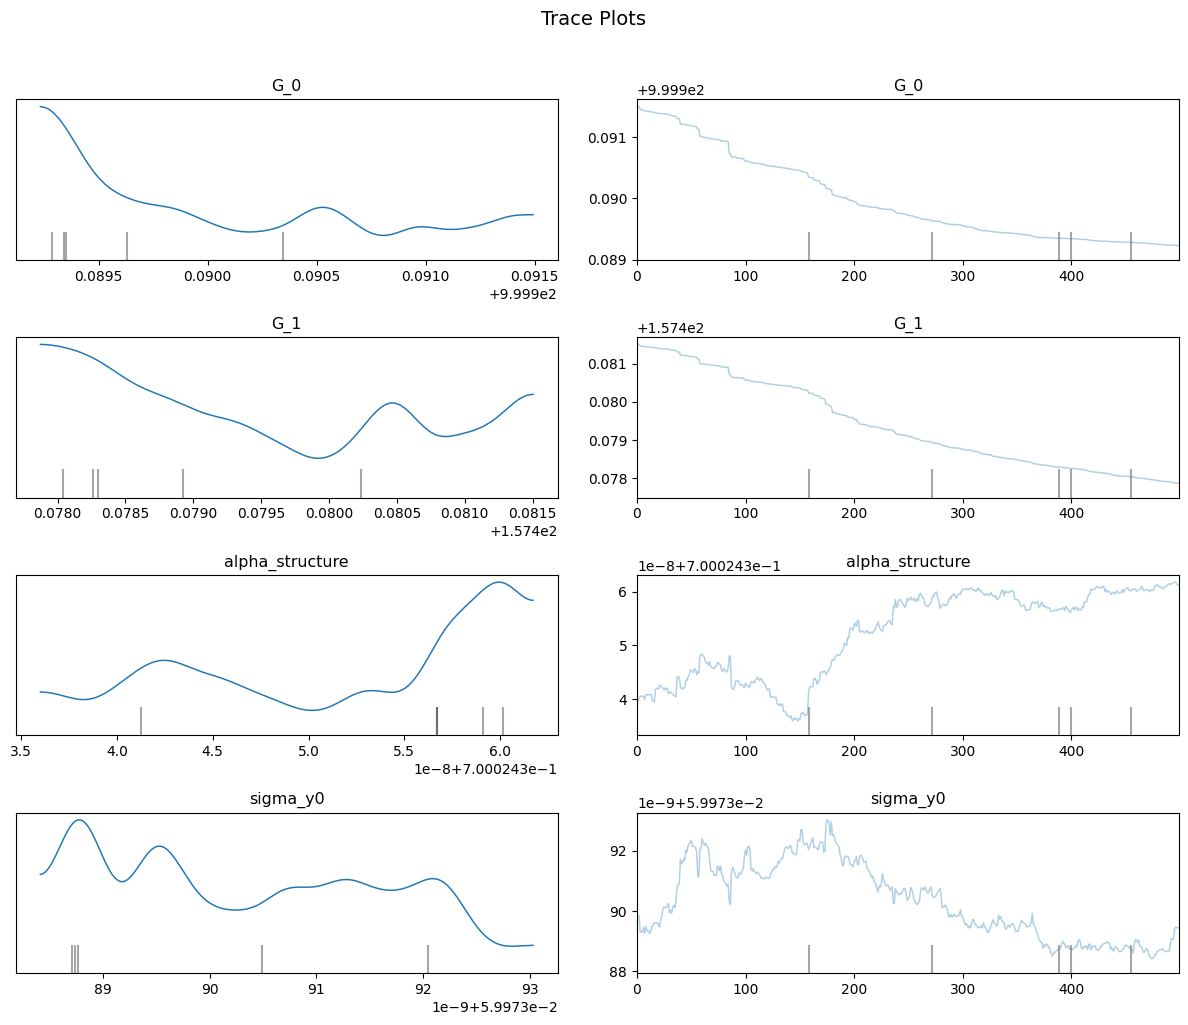

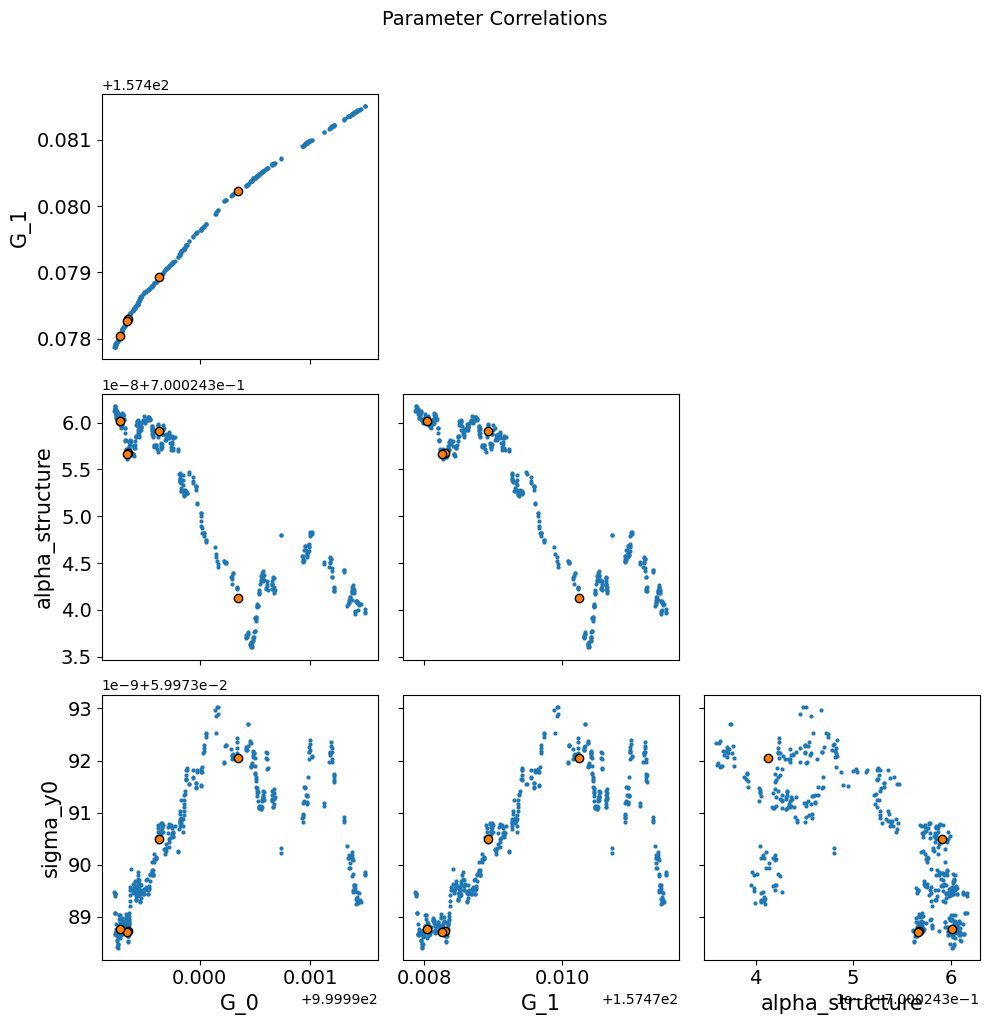

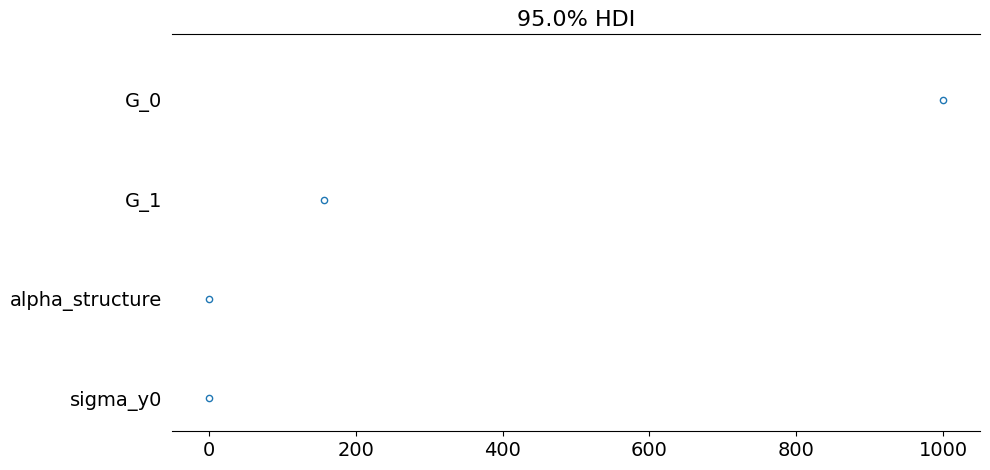

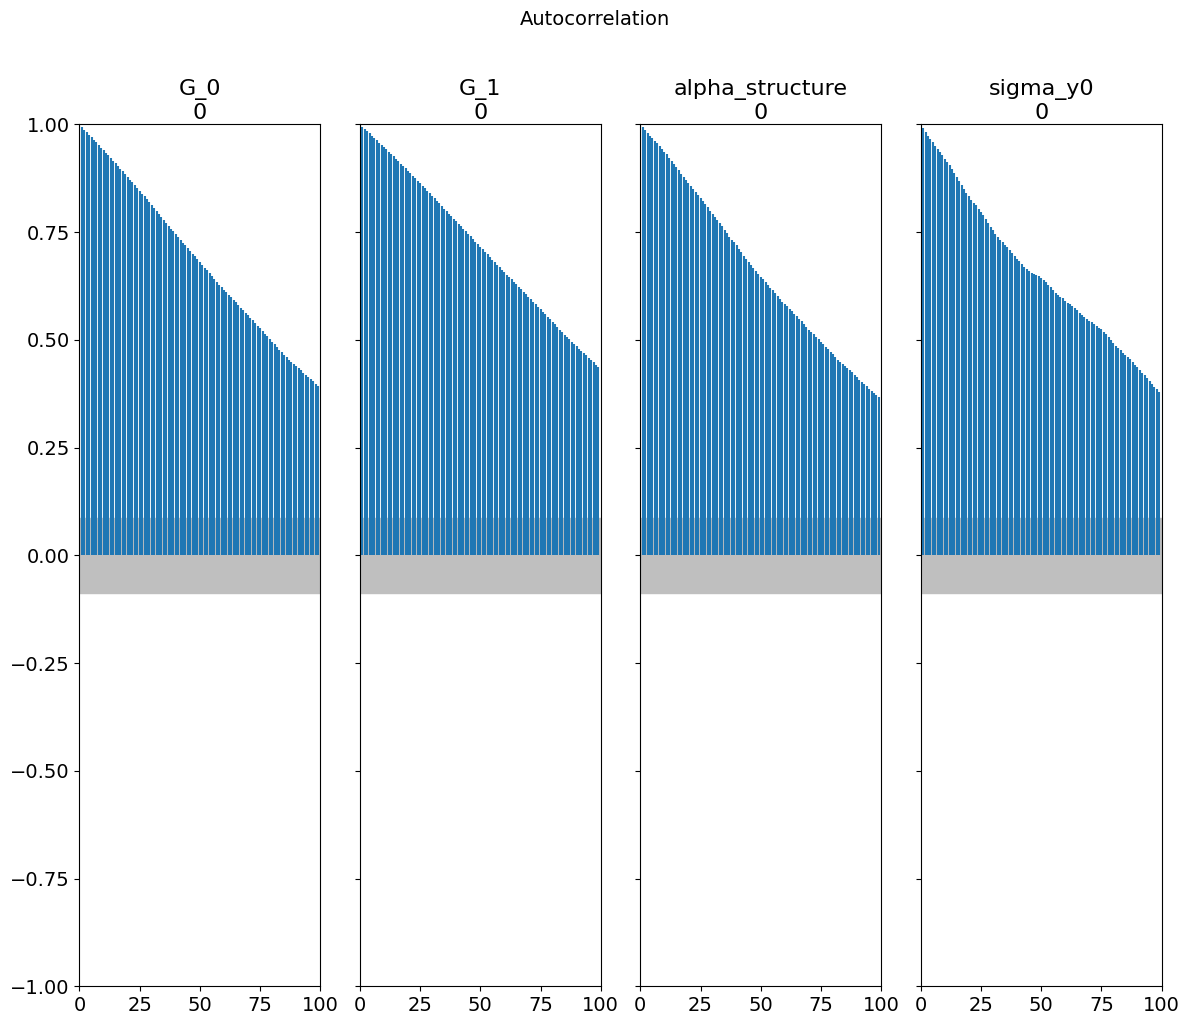

In [8]:
key_params = ["G_0", "G_1", "alpha_structure", "sigma_y0"]
print_convergence_summary(result, key_params)

print("\n### Diagnostic Interpretation")
print("| Metric | Target | Meaning |")
print("|--------|--------|---------|")
print("| **R-hat** | < 1.01 | Chain mixing quality |")
print("| **ESS** | > 400 | Independent samples |")
print("| **Divergences** | < 1% | NUTS quality |")

display_arviz_diagnostics(result, key_params, fast_mode=FAST_MODE)

### Convergence Diagnostics

**Diagnostic Targets:**

| Metric | Target | Meaning |
|--------|--------|---------|
| **R-hat** | < 1.01 | Chain mixing quality |
| **ESS** | > 400 | Independent samples |
| **Divergences** | < 1% | NUTS quality |

## 5. Save Results

In [9]:
save_fikh_results(model, result, "fmlikh", "startup", param_names)

Results saved to /Users/b80985/Projects/rheojax/examples/utils/../outputs/fikh/fmlikh/startup/
  nlsq_params_startup.json: 20 parameters
  posterior_startup.json: 500 draws


## Key Takeaways

1. **FMLIKH startup shows multiple overshoot features** from different modes
2. **Fast modes → early sharp overshoot; slow modes → late extended tail**
3. **Fractional kinetics broadens each mode's contribution**
4. **Composite stress captures complex experimental startup curves**
5. **Mode decomposition reveals structural level contributions**
6. **Residual analysis** validates multi-mode transient dynamics

---

## Further Reading

- **[FMLIKH Startup Analysis](../../docs/source/models/fikh/fmlikh.rst#distributed-fractional-kinetics)**: Multi-mode transient equations
- **[Mode Decomposition](../../docs/source/models/fikh/fmlikh.rst#hierarchical-microstructure-interpretation)**: Relating modes to physical structure

### Key References

1. Wei, Y., Solomon, M.J., & Larson, R.G. (2018). "A multimode structural kinetics constitutive equation." *J. Rheol.*, 62(1), 321-342.
2. Jaishankar, A. & McKinley, G.H. (2014). "A fractional K-BKZ constitutive formulation." *J. Rheol.*, 58, 1751-1788.

### Next Steps

**Next**: NB09 (Stress Relaxation) — multi-exponential decay with power-law tails